# A/B-тест для интернет-магазина

##  Описание проекта

Крупному интернет-магазину вместе с отделом маркетинга необходимо подготовить список гипотез для увеличения выручки.
Приоритизируем гипотезы, запустим A/B-тест и проанализируем результаты. 

**Описание данных**

Данные для первой части

Файл /datasets/hypothesis.csv. 

- Hypothesis — краткое описание гипотезы;
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Данные для второй части

Файл /datasets/orders.csv. 

- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.

Файл /datasets/visitors.csv.

- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста


## Импорт библиотек, загрузка данных, предобработка.

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import scipy.stats as stats
from pandas.plotting import register_matplotlib_converters
import warnings
# конвертеры, которые позволяют использовать типы pandas в matplotlib  
register_matplotlib_converters()


In [2]:
#загрузка данных
orders = pd.read_csv('/datasets/orders.csv', sep=',')

orders.head()

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


In [3]:
visitors = pd.read_csv('/datasets/visitors.csv')

visitors.head()


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


In [4]:
hypothesis = pd.read_csv('/datasets/hypothesis.csv')
pd.set_option('display.max_colwidth', None)
hypothesis.head()

,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1


В таблице hypothesis приведем к нижнему регистру названия столбцов

In [5]:
hypothesis.columns = map(str.lower, hypothesis.columns)

In [6]:
#проверим названия столбцов
hypothesis.columns

Index(['hypothesis', 'reach', 'impact', 'confidence', 'efforts'], dtype='object')

На первый взгляд все хорошо. Выведем общую информацию о таблицах и посмотрим на количество пропусков и дубликатов.

In [7]:
dataset = [hypothesis, orders, visitors]

for d in dataset:
    print('Общая информация: ')
    display(d.info())
    print('Пропуски: ')
    display(d.isna().sum())
    print('Дубликаты: ')
    display(d.duplicated().sum())

Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   hypothesis  9 non-null      object
 1   reach       9 non-null      int64 
 2   impact      9 non-null      int64 
 3   confidence  9 non-null      int64 
 4   efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


None

Пропуски: 


hypothesis    0
reach         0
impact        0
confidence    0
efforts       0
dtype: int64

Дубликаты: 


0

Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


None

Пропуски: 


transactionId    0
visitorId        0
date             0
revenue          0
group            0
dtype: int64

Дубликаты: 


0

Общая информация: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


None

Пропуски: 


date        0
group       0
visitors    0
dtype: int64

Дубликаты: 


0

В таблицах visitors и orders в  столбце date  преобразуем данные о времени. 

In [8]:
visitors['date'] = visitors['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [9]:
#проверим тип данных
visitors.dtypes

date        datetime64[ns]
group               object
visitors             int64
dtype: object

In [10]:
orders['date'] = orders['date'].map(
    lambda x: dt.datetime.strptime(x, '%Y-%m-%d')
)

In [11]:
orders.dtypes

transactionId             int64
visitorId                 int64
date             datetime64[ns]
revenue                   int64
group                    object
dtype: object

Тип данных успешно изменен.

Таким образом мы выгрузили датасеты и подготовили таблицы для дальнейшего анализа. А именно: изучили общую информацию, посмотрели на тип данных, проверили пропуски и дубликаты. Как видим данные не содержат пропусков и дубликатов, поэтому только было изменено тип данных для дат и названия столбцов переведено в удобный формат. Можно приступать к вычислениям.

## Часть 1. Приоритизация гипотез.

Применим фреймворк ICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.


In [12]:
pd.set_option('display.max_colwidth', None)

hypothesis ['ICE']= round(hypothesis ['impact'] * hypothesis['confidence'] /hypothesis ['efforts'], 2)

hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False)

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.20
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.33
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.20
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.00
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.00
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.00
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.33
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.12
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.00


Как видим наиболее перспективная гипотеза 8: запустить акцию, дающую скидку на товар в день рождения. А так же гипотезы под номером  0 и 7

Применим фреймворк RICE для приоритизации гипотез. Отсортируем их по убыванию приоритета.

In [13]:
hypothesis ['RICE']= hypothesis ['reach'] * hypothesis ['impact'] * hypothesis ['confidence'] /hypothesis ['efforts']
hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False)

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


Наиболее перспективные гипотезы 7, 2 и 0. Лидер гипотеза 7: добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

Как изменилась приоритизация гипотез при применении RICE вместо ICE

По методу ICE, наибольший приоритет имеет гипотеза 8, предлагающая запустить акцию, дающую скидку на товар в день рождения пользователя. По методу Rice, наиболее приоритетна гипотеза 7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email рассылок.

Такая разница в результатах, вероятно, связана с тем, что метод ICE не учитывает, скольких пользователей затронет вносимое изменение. Акция, дающая скидку на товар в день рождения пользователя, затронет только часть пользователей - тех, кто указал свою дату рождения, и не затронет единовременно всех пользователей. Форма подписки на всех основных страницах затронет большую часть пользователей интернет-магазина.

## Часть 2. Анализ A/B-теста.

1. Построим график кумулятивной выручки по группам.

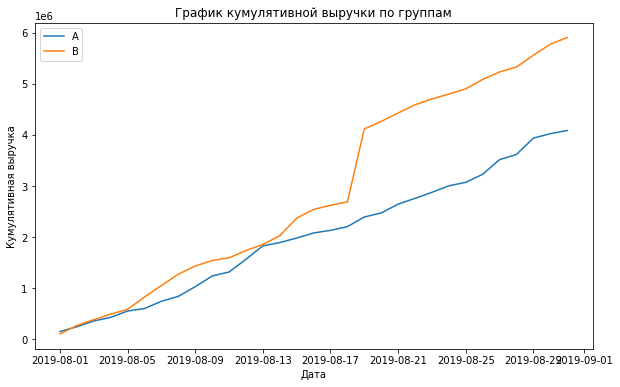

In [14]:
datesGroups = orders[['date', 'group']].drop_duplicates()

ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transactionId': 'nunique',
            'visitorId': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]
plt.figure(figsize=(10, 6))

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')

plt.xlabel('Дата')
plt.ylabel('Кумулятивная выручка')
plt.title(label='График кумулятивной выручки по группам')
plt.legend() 
plt.show()

В середине теста сегмент B вырвался вперёд и в дальнейшем лидировал весь остаток теста.
Возможно, на данные повлияли аномально большие покупки, но также возможно, что количество заказов стало больше - в начале вычислений мы уже установили, что в группе В сделали больше заказов.

2. Построим график кумулятивного среднего чека по группам.

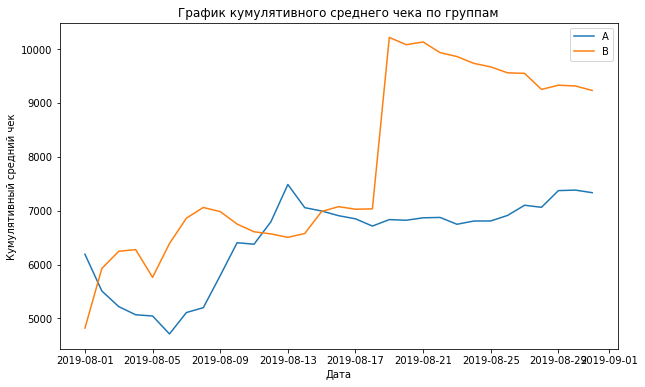

In [15]:
plt.figure(figsize=(10,6))
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.xlabel('Дата')
plt.ylabel('Кумулятивный средний чек')
plt.title(label='График кумулятивного среднего чека по группам')
plt.legend() 
plt.show()

Кумулятивное значение среднего чека по сегментам продолжает колебаться. Скорее всего, принимать решение по этой метрике рано. Или требуется дополнительный анализ выбросов, которые так сильно искажают результаты.

3. Построим график относительного изменения кумулятивного среднего чека группы B к группе A.

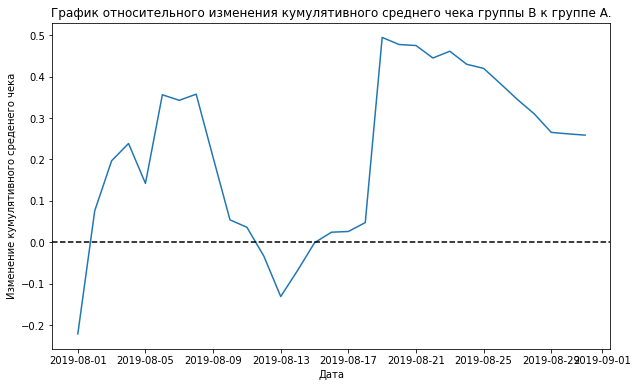

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10,6))
# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--') 
plt.xlabel('Дата')
plt.ylabel('Изменение кумулятивного среденего чека')
plt.title(label='График относительного изменения кумулятивного среднего чека группы B к группе A.')
plt.show()

Результаты теста значительно и резко менялись в несколько дат. Видимо, именно тогда были совершены аномальные заказы.

4. Построим график кумулятивного среднего количества заказов на посетителя по группам. 

In [17]:
#период проведения эксперимента
print(min(visitors['date']))
max(visitors['date'])

2019-08-01 00:00:00


Timestamp('2019-08-31 00:00:00')

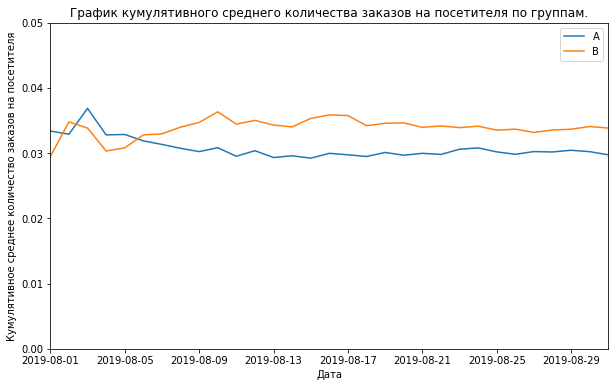

In [18]:
# считаем кумулятивную среднее количество заказов на посетителя
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

plt.figure(figsize=(10,6))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')

plt.xlabel('Дата')
plt.ylabel('Кумулятивное среднее количество заказов на посетителя')
plt.title(label='График кумулятивного среднего количества заказов на посетителя по группам.')
plt.legend()

# задаем масштаб осей
plt.axis([dt.datetime(2019, 8, 1), dt.datetime(2019, 8, 31), 0, 0.05])
plt.show()

Сначала сегмент А имел большую конверсию, но чуть позже сегмент В выровнялся и зафиксировался больше значения сегмента А.

5. Построим график относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A.

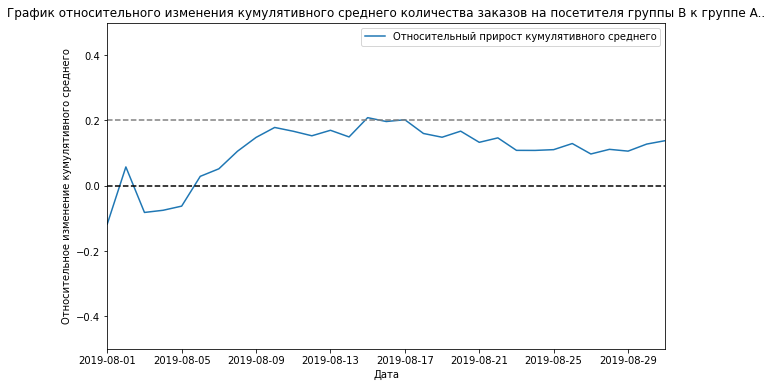

In [19]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.figure(figsize=(10, 6))
plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, 
label="Относительный прирост кумулятивного среднего")
plt.legend()
plt.xlabel('Дата')
plt.ylabel('Относительное изменение кумулятивного среднего')
plt.title(label='График относительного изменения кумулятивного среднего количества заказов на посетителя группы B к группе A..')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=0.2, color='grey', linestyle='--')
plt.axis(["2019-08-01", '2019-08-31', -0.5, 0.5]);
plt.show()

Почти с самого начала группа В лидирует по конверсии. Приняла стабильные +15% относительно группы А.

6. Построим точечный график количества заказов по пользователям. 

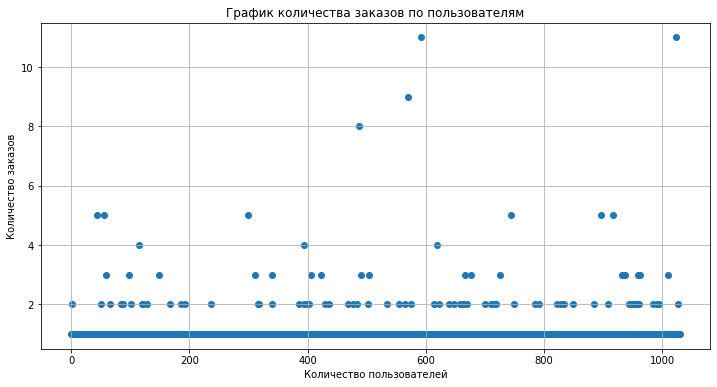

In [20]:
ordersByUsers = orders.drop(['group', 'revenue', 'date'], axis=1).groupby('visitorId', as_index=False). \
                                                                        agg({'transactionId' : pd.Series.nunique})

ordersByUsers.columns = ['user_id','orders']

ordersByUsers.sort_values(by='orders',ascending=False).head(10)

# серия из чисел от 0 до количества наблюдений в ordersByUsers
plt.figure(figsize=(12,6))
plt.grid()
plt.title('График количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов')
x_values = pd.Series(range(0, len(ordersByUsers)))
plt.scatter(x_values, ordersByUsers['orders']) 
plt.show()

Судяпо графику больше всего пользователей совершивших 1 заказ. Совершивших  2 и 3 заказа единицы, возможно они будут являться выбросами, стоит посчитать выборочные перцентили.

7. Посчитаем 95-й и 99-й перцентили количества заказов на пользователя. Выберим границу для определения аномальных пользователей.

In [21]:
print(np.percentile(ordersByUsers['orders'], [95, 99])) 

[2. 4.]


95% пользователей овершают не больше 2 заказов, 99% совершают 4 заказа, аномальным будет всё, что и более этого.

8. Построим точечный график стоимостей заказов.

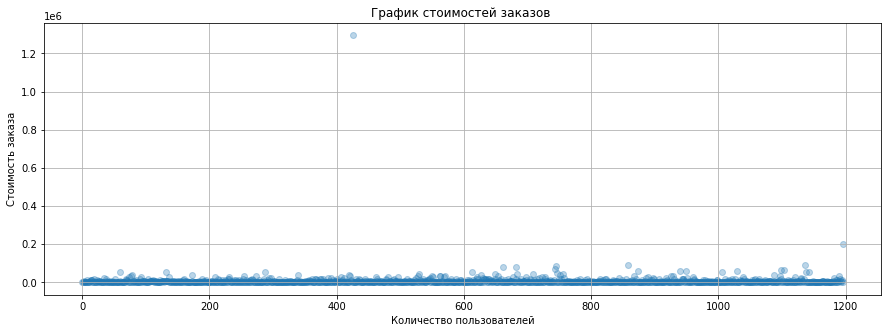

In [22]:
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.figure(figsize=(15,5))
plt.grid()
plt.title('График стоимостей заказов ')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.scatter(x_values, orders['revenue'], alpha=0.3)
plt.show()

График из-за одного выброса в 1,2 млн. получился ненаглядным. Увеличим масштаб

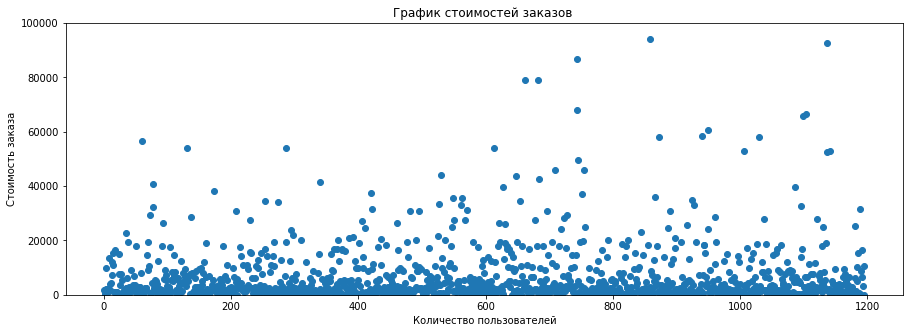

In [23]:
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.figure(figsize=(15, 5))

plt.title('График стоимостей заказов ')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказа')
plt.ylim(0, 100000)
plt.scatter(x_values, orders['revenue'])
plt.show()

Теперь хорошо видно, что больше всего заказов в районе 10000 рублей и ниже.

9. Посчитаем 95-й и 99-й перцентили стоимости заказов. Выберем границу для определения аномальных заказов.

In [24]:
np.percentile(orders['revenue'], [95, 99])

array([28000. , 58233.2])

Не больше, чем у 5% заказов чек дороже 28 000 рублей, и только у 1% - дороже 58 233 р. Такой процентиль подтвержает выброс на графике в 1,2 млн. руб. Будем считать аномаными свыше 4 заказов на сумму больше 58233 руб.

10. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «сырым» данным. 

Для проверки всех гипотез воспользуемся методом st.mannwhitneyu(), так как в данных есть большие (по сравнению с нормальным распределением) выбросы.

Нулевая гипотеза: среднее количество заказов на посетителя между группами А и В не отличаются.

Альтернативная гипотеза: среднее количество заказов на посетителя между группами А и В имеют статистически значимые отличия.

Уровень значимости принимаем за 0.05.

In [25]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transactionId', 'visitorId', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transactionId': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)


ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersA.columns = ['visitorId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitorId', as_index=False)
    .agg({'transactionId': pd.Series.nunique})
)
ordersByUsersB.columns = ['visitorId', 'orders']

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print("{0:.5f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.01679
0.138


Отвергаем нулевую гипотезу - p-value меньше 0.05, группа В имеет показатели выше на 13.8%.

11. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. 

За нулевую гипотезу H0 примем - статистически значимых различий в среднемчеке между группами нет.
Тогда альтернативная гипотеза Н1 - статистически значимые различия есть.

In [26]:
print('{0:.3f}'.format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value выше 0.05 мы не можем опровергнуть нулевую гипотезу. Анализ "сырых" данных показал, что в среднем количестве заказов между группами нет статистически значимых различий, а вот средние чеки значимо отличаются. Относительный прирост среднего группы В к среднему группы А равен 13,8%, а прирост среднего чека - 25,9%.

12. Посчитаем статистическую значимость различий в среднем количестве заказов на посетителя между группами по «очищенным» данным.

In [27]:
#список аномальных пользователей
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > int(np.percentile(ordersByUsers['orders'], [99]))]['visitorId'],
        ordersByUsersB[ordersByUsersB['orders'] > int(np.percentile(ordersByUsers['orders'], [99]))]['visitorId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > int(np.percentile(orders['revenue'], [99]))]['visitorId']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))

1099     148427295
949      887908475
744      888512513
1103    1164614297
1136    1307669133
Name: visitorId, dtype: int64


Нулевая гипотеза: среднее количество заказов на посетителя между группами не отличается.

Альтернативная гипотеза: среднее количество заказов на посетителя между группами имеет статистически значимое отличие.

Уровень значимости принимаем за 0.05.



In [28]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['visitorId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

print('{0:.5f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.01438
0.153


Отвергаем нулевую гипотезу - p-value меньше 0.05, статистически значимые отличия - разница составляет 15%.


13. Посчитаем статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным.

Нулевая гипотеза: средний чек посетителя между группами не отличается.

Альтернативная гипотеза: средний чек посетителя между группами имеет статистически значимое отличие.

Уровень значимости принимаем за 0.05.

In [29]:
print(
    '{0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitorId'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitorId'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.851
-0.006


P-value выше 0.05 мы не можем опровергнуть нулевую гипотезу. Анализ "сырых" данных показал, что средний чек посетителя между группами не отличается.

В ходе вычислений установлено, что:

- по сырым данным нет статистически значимого различия по среднему количеству заказов, после удаления аномалий также значимого различия не выявлено;
- есть статистически значимое различие в среднем чеке между группами как по сырым данным, так и после фильтрации аномалий;
- график различия среднего чека сильно колеблется, вероятно, из-за аномалий. Он не позволяет сделать значимых выводов, но позволил выявить наличие аномалий.

Тест можно остановить и признать успешным. График конверсии пришёл к стабильности, группа В статистически значимо лучше группы А

## Вывод.

В начале работы мы выгрузили датасеты и подготовили таблицы для дальнейшего анализа. А именно: изучили общую информацию, посмотрели на тип данных, проверили пропуски и дубликаты. Как видим данные не содержат пропусков и дубликатов, поэтому только было изменено тип данных для дат и названия столбцов переведено в удобный формат. Можно приступать к вычислениям.


Затем применили фреймворк ICE и RICE.
По методу ICE, наибольший приоритет имеет гипотеза 8, предлагающая запустить акцию, дающую скидку на товар в день рождения пользователя. По методу Rice, наиболее приоритетна гипотеза 7 - добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email рассылок.

Такая разница в результатах, вероятно, связана с тем, что метод ICE не учитывает, скольких пользователей затронет вносимое изменение. Акция, дающая скидку на товар в день рождения пользователя, затронет только часть пользователей - тех, кто указал свою дату рождения, и не затронет единовременно всех пользователей. Форма подписки на всех основных страницах затронет большую часть пользователей интернет-магазина.

В ходе вычислений установлено, что:

- по сырым данным нет статистически значимого различия по среднему количеству заказов, после удаления аномалий также значимого различия не выявлено;
- есть статистически значимое различие в среднем чеке между группами как по сырым данным, так и после фильтрации аномалий;
- график различия среднего чека сильно колеблется, вероятно, из-за аномалий. Он не позволяет сделать значимых выводов, но позволил выявить наличие аномалий.

Тест можно остановить и признать успешным. График конверсии пришёл к стабильности, группа В статистически значимо лучше группы А

Отделу маркетинга  рекомендуется начать работу по стимуляции к увеличению среднего чека.